In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
import glob
import matplotlib.pyplot as plt

awkward version  1.7.0
coffea version  0.7.11


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hhyxn9yn because the default path (/home/cms-jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
eras = [
    'UL16NanoAOD', 
    'UL16NanoAODAPV', 
    'UL17NanoAOD', 
    'UL18NanoAOD'
       ]

filestr1 = '/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/*/*.root'
filestr2 = '/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/*/*.root'
fileset = {"2016":[], "2016APV":[]}


infiles1 = glob.glob(filestr1)
fileset["2016"] = fileset["2016"] + [*infiles1]
infiles2 = glob.glob(filestr2)
fileset["2016APV"] = fileset["2016APV"] + [*infiles2]

In [3]:
class Counter(processor.ProcessorABC):
    def __init__(self ):
        weights_axis = hist.axis.Regular(1000, 0, 1, name="w", label="Weights")
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        
        ### Plots of things during the selection process / for debugging with fine binning
        h_w = hist.Hist(dataset_axis, weights_axis, storage="weight", label="Counts")
        
        self.hists = {
            "w":h_w
        }
        
        self.means_stddevs = defaultdict()
    
    @property
    def accumulator(self):
        return self.hists

    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        dataset = events.metadata['dataset']

        self.hists['w'].fill( dataset=dataset, w=events["Generator"].weight )
        
        if ak.any( events["Generator"].weight > 1.0 ):
            print("Weird events: ", events["Generator"].weight)
        
        return self.hists

    
    def postprocess(self, accumulator):
        return accumulator
    
    
    

In [4]:
run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=8),
    schema=NanoAODSchema,
    chunksize=1000000,
    maxchunks=10
)

output = run(
    fileset,
    "Events",
    processor_instance=Counter(),
)

Preprocessing:   0%|          | 0/44 [00:00<?, ?file/s]

Processing:   0%|          | 0/20 [00:00<?, ?chunk/s]

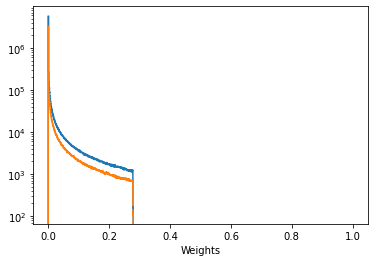

In [5]:
output['w'].plot()
plt.yscale("log")

In [6]:
output["w"].values()

array([[5714664.,  263384.,  157412., ...,       0.,       0.,       0.],
       [3296955.,  152967.,   90926., ...,       0.,       0.,       0.]])